📊 Bu EDA Ne Yapacak?

Veri Kalitesi: Missing values, duplicates, veri tipi kontrolleri
Label Dağılımı: 30 kategorinin dengeli olup olmadığı
Metin Analizi: Sorgu uzunlukları, kelime sayıları
Common Words: En sık kullanılan kelimeler
Word Cloud: Görsel analiz
Kategori Analizi: Her kategorinin özelliklerini anlama

# Exploratory Data Analysis - Ryanair Customer Query Classification
### **Objective**: Understand the dataset structure, distribution, and patterns to inform model development strategy.
### **Author**: Enes Ozyaramıs 
### **Date**: 20/07/2025

# 📋 Table of Contents
### 1. [Data Loading & Basic Info]
### 2. [Dataset Overview]
### 3. [Label Distribution Analysis]
### 4. [Text Analysis]
### 5. [Data Quality Assessment]
### 6. [Key Insights & Next Steps]

In [1]:
# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from wordcloud import WordCloud

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Style settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All libraries imported successfully!")

All libraries imported successfully!


##  1. Data Loading & Basic Info

In [2]:
# %%
# Load datasets
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
train_path = os.path.join(ROOT, 'data', 'raw', 'customer_queries_data.csv')
test_path  = os.path.join(ROOT, 'data', 'raw', 'customer_queries_test.csv')
train_data = pd.read_csv(train_path)
test_data  = pd.read_csv(test_path)
print("Data Loading Summary")
print("=" * 50)
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(f"Training columns: {list(train_data.columns)}")
print(f"Test columns: {list(test_data.columns)}")

Data Loading Summary
Training set shape: (20000, 2)
Test set shape: (5977, 1)
Training columns: ['query', 'label']
Test columns: ['query']


In [3]:
# %%
# Display first few rows
print("Training Data Sample:")
print(train_data.head())
print("\nTest Data Sample:")
print(test_data.head())

Training Data Sample:
                                               query                    label
0  I'm having trouble accessing my Ryanair custom...  Customer Account Issues
1         Can I change my flight date after booking?           Flight Changes
2           Why was my credit card payment rejected?           Payment Issues
3  How can I change the date of my flight reserva...           Flight Changes
4  What are the policies for traveling with an in...  Child and Infant Travel

Test Data Sample:
                                               query
0  Am I able to choose my seat during the flight ...
1  Am I eligible for a refund if my flight is can...
2                   Any current travel restrictions?
3                      App crashes on startup. Help!
4            Are animals allowed on Ryanair flights?


In [4]:
# %%
# Basic information about datasets
print("Training Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5977 entries, 0 to 5976
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   5977 non-null   object
dtypes: object(1)
memory usage: 46.8+ KB
None


##  2. Dataset Overview

In [5]:
# %%
# Check for missing values
print("Missing Values Analysis:")
print("=" * 40)
print("Training Data:")
print(train_data.isnull().sum())
print("\nTest Data:")
print(test_data.isnull().sum())

Missing Values Analysis:
Training Data:
query    0
label    0
dtype: int64

Test Data:
query    0
dtype: int64


In [6]:
# %%
# Check for duplicates
print("Duplicate Analysis:")
print("=" * 30)
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
print(f"Training set duplicates: {train_duplicates}")
print(f"Test set duplicates: {test_duplicates}")

if train_duplicates > 0:
    print("\n Sample duplicate queries:")
    duplicate_queries = train_data[train_data.duplicated(subset=['query'], keep=False)]
    print(duplicate_queries.head())

Duplicate Analysis:
Training set duplicates: 0
Test set duplicates: 1


In [7]:
dup = test_data[test_data.duplicated(subset=['query'], keep=False)]
print(dup)

                                                 query
867  Can I earn loyalty points on all Ryanair flights?
868  Can I earn loyalty points on all Ryanair flights?


In [8]:
test_data = test_data.drop_duplicates(subset=['query'], keep='first').reset_index(drop=True)

##  3. Label Distribution Analysis

In [9]:
# %%
# Analyze label distribution
label_counts = train_data['label'].value_counts()
print(" Label Distribution:")
print("=" * 30)
print(f"Total unique labels: {len(label_counts)}")
print(f"Most common label: {label_counts.index[0]} ({label_counts.iloc[0]} samples)")
print(f"Least common label: {label_counts.index[-1]} ({label_counts.iloc[-1]} samples)")
print(f"\nClass balance ratio (max/min): {label_counts.iloc[0] / label_counts.iloc[-1]:.2f}")

 Label Distribution:
Total unique labels: 30
Most common label: Payment Issues (907 samples)
Least common label: Partnerships and Alliances (416 samples)

Class balance ratio (max/min): 2.18


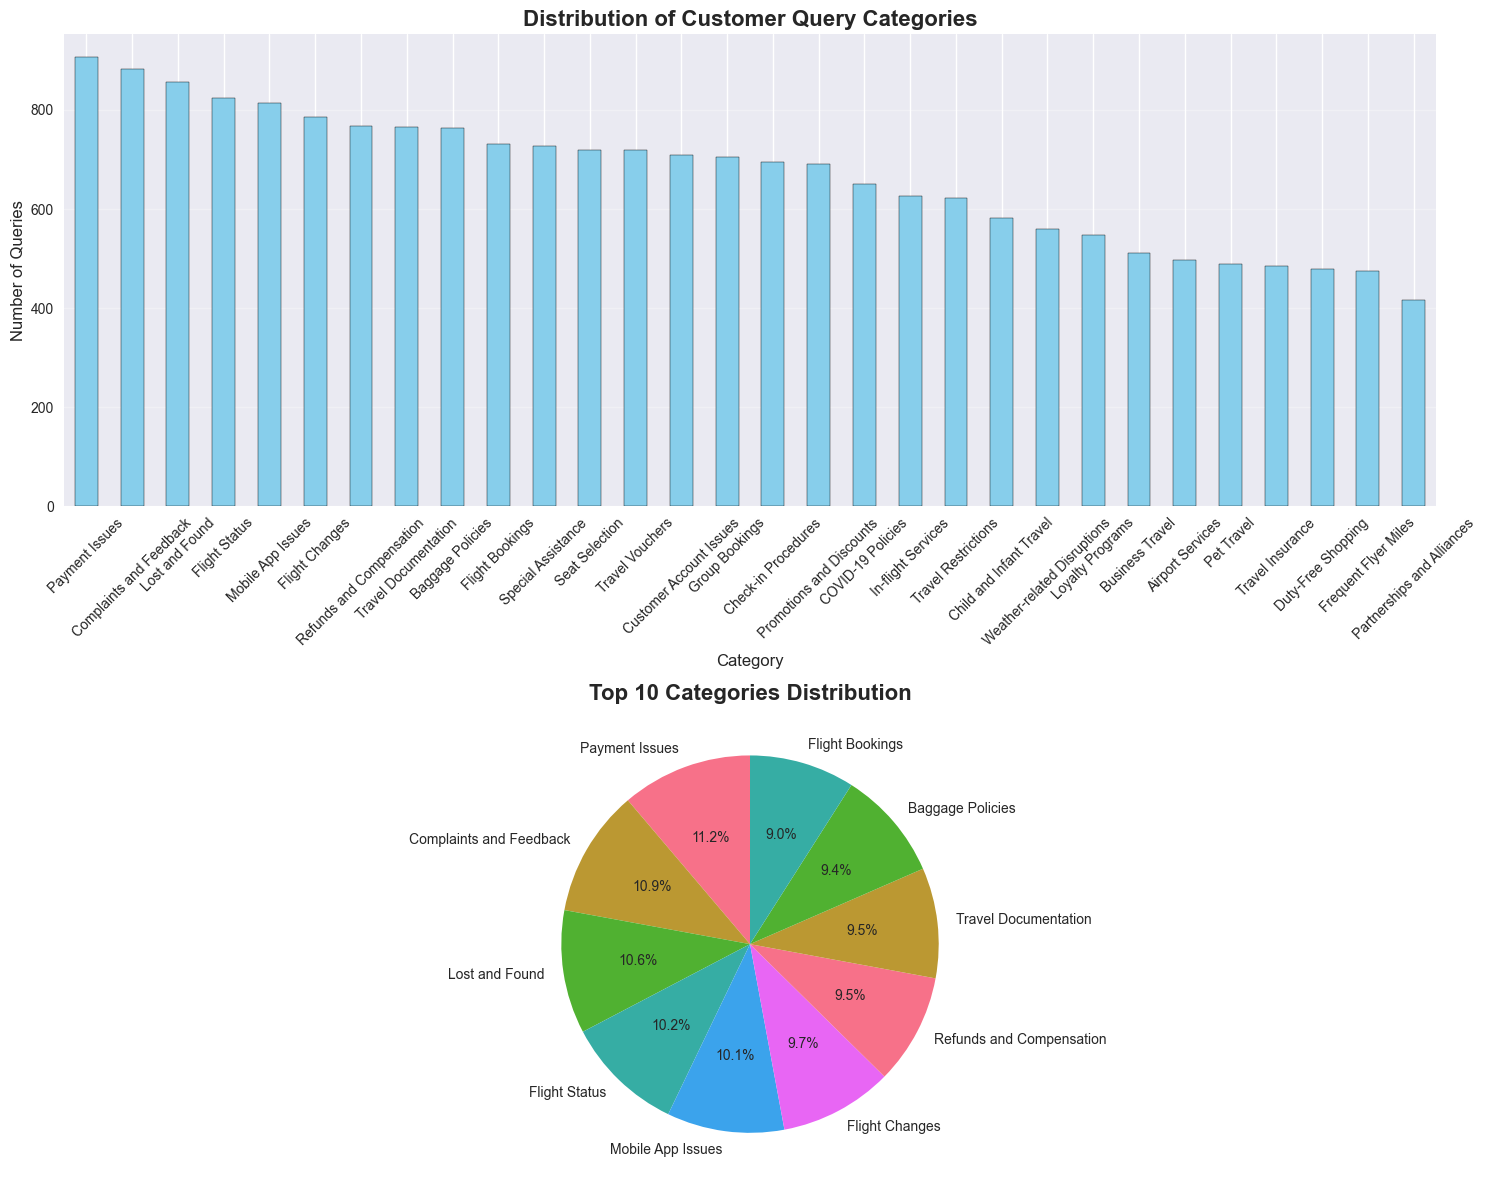

In [12]:
# %%
# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Customer Query Categories', fontsize=16, fontweight='bold')
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Number of Queries', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Pie chart for top 10 categories
top_10_labels = label_counts.head(10)
ax2.pie(top_10_labels.values, labels=top_10_labels.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 10 Categories Distribution', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# %%
# Statistical summary of label distribution
print("Label Distribution Statistics:")
print("=" * 40)
print(f"Mean samples per class: {label_counts.mean():.2f}")
print(f"Median samples per class: {label_counts.median():.2f}")
print(f"Standard deviation: {label_counts.std():.2f}")
print(f"Min samples: {label_counts.min()}")
print(f"Max samples: {label_counts.max()}")

# Calculate class imbalance
percentages = (label_counts / len(train_data) * 100).round(2)
print(f"\nClass percentage range: {percentages.min():.2f}% - {percentages.max():.2f}%")

Label Distribution Statistics:
Mean samples per class: 666.67
Median samples per class: 700.00
Standard deviation: 136.13
Min samples: 416
Max samples: 907

Class percentage range: 2.08% - 4.54%


## 4. Text Analysis

In [14]:
# %%
# Text length analysis
train_data['query_length'] = train_data['query'].str.len()
train_data['word_count'] = train_data['query'].str.split().str.len()

print(" Text Length Statistics:")
print("=" * 35)
print("Character length:")
print(train_data['query_length'].describe())
print("\nWord count:")
print(train_data['word_count'].describe())

 Text Length Statistics:
Character length:
count    20000.000000
mean        71.890850
std         30.957586
min         16.000000
25%         52.000000
50%         61.000000
75%         81.000000
max        273.000000
Name: query_length, dtype: float64

Word count:
count    20000.000000
mean        12.952750
std          5.351304
min          3.000000
25%          9.000000
50%         11.000000
75%         15.000000
max         47.000000
Name: word_count, dtype: float64


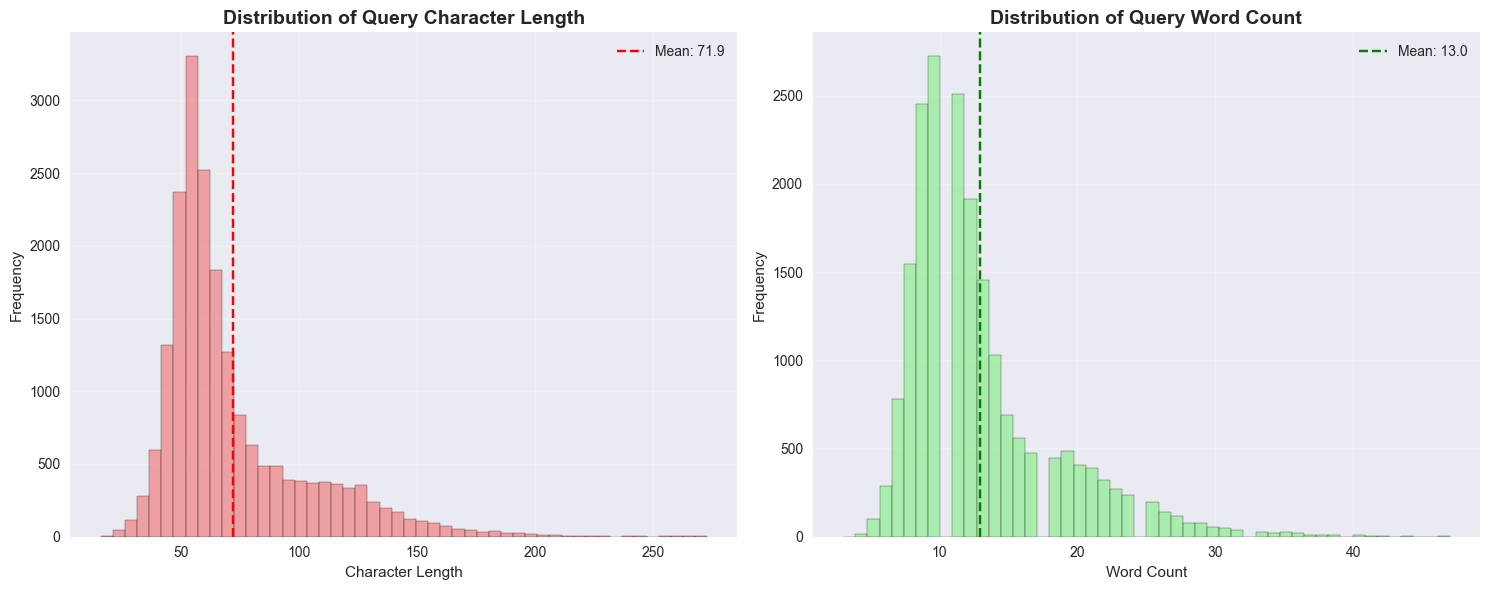

In [15]:
# %%
# Visualize text length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Character length distribution
ax1.hist(train_data['query_length'], bins=50, color='lightcoral', alpha=0.7, edgecolor='black')
ax1.set_title('Distribution of Query Character Length', fontsize=14, fontweight='bold')
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.axvline(train_data['query_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_data["query_length"].mean():.1f}')
ax1.legend()
ax1.grid(alpha=0.3)

# Word count distribution
ax2.hist(train_data['word_count'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Query Word Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.axvline(train_data['word_count'].mean(), color='green', linestyle='--', label=f'Mean: {train_data["word_count"].mean():.1f}')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# %%
# Text length by category analysis
category_text_stats = train_data.groupby('label').agg({
    'query_length': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(2)

print(" Text Statistics by Category (Top 10):")
print("=" * 50)
top_categories = label_counts.head(10).index
print(category_text_stats.loc[top_categories])

 Text Statistics by Category (Top 10):
                         query_length               word_count             
                                 mean median    std       mean median   std
label                                                                      
Payment Issues                  69.01   60.0  28.02      12.83   11.0  4.93
Complaints and Feedback         73.39   65.0  28.99      13.58   12.0  5.25
Lost and Found                  66.47   57.0  27.96      14.41   13.0  5.48
Flight Status                   62.37   56.0  24.48      12.50   11.0  4.74
Mobile App Issues               69.01   59.5  29.79      12.77   11.0  5.01
Flight Changes                  66.12   57.0  27.88      12.73   11.0  5.25
Refunds and Compensation        71.12   63.0  28.17      13.79   12.0  5.18
Travel Documentation            71.02   61.0  28.22      12.57   11.0  4.86
Baggage Policies                65.85   57.0  28.74      11.59   10.0  4.95
Flight Bookings                 66.60   60.0  24.

In [17]:
# %%
# Analyze common words across all queries
stop_words = set(stopwords.words('english'))

def get_common_words(text_series, n=20):
    """Extract most common words from text series."""
    all_text = ' '.join(text_series.astype(str))
    words = word_tokenize(all_text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return Counter(words).most_common(n)

common_words = get_common_words(train_data['query'])
print("🔤 Most Common Words (excluding stop words):")
print("=" * 45)
for word, count in common_words:
    print(f"{word}: {count}")

🔤 Most Common Words (excluding stop words):
ryanair: 11189
flight: 8260
travel: 2971
booking: 2431
flights: 2268
need: 1921
available: 1404
special: 1308
book: 1225
services: 1145
restrictions: 979
app: 904
payment: 876
airport: 873
process: 850
provide: 848
seat: 818
offer: 812
online: 806
assistance: 804


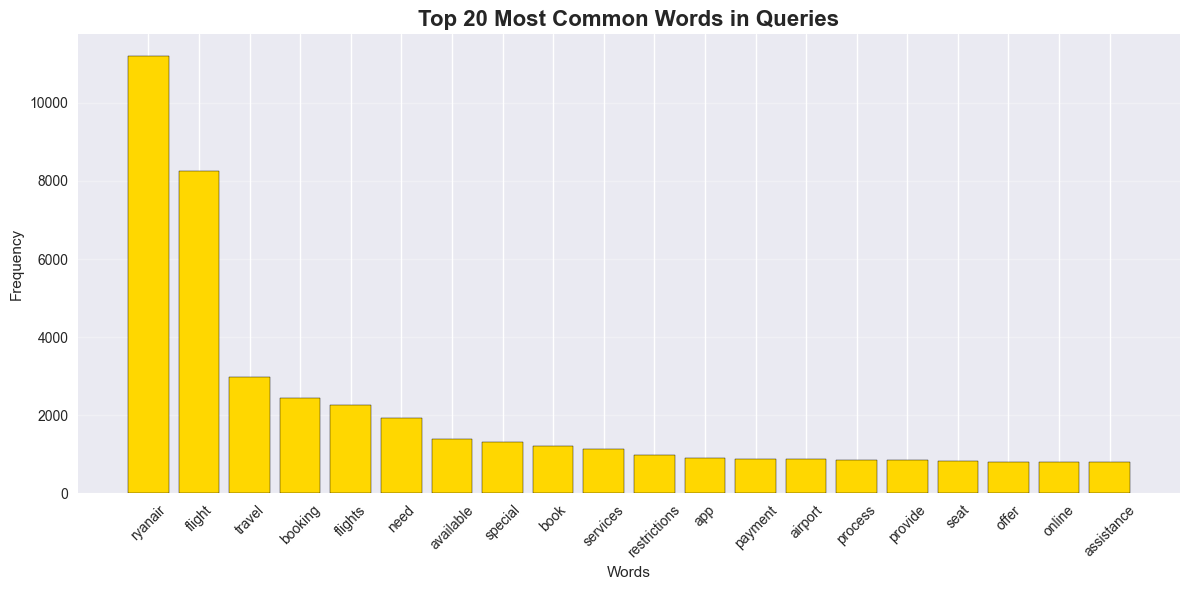

In [18]:
# %%
# Visualize common words
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='gold', edgecolor='black')
plt.title('Top 20 Most Common Words in Queries', fontsize=16, fontweight='bold')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/common_words.png', dpi=300, bbox_inches='tight')
plt.show()

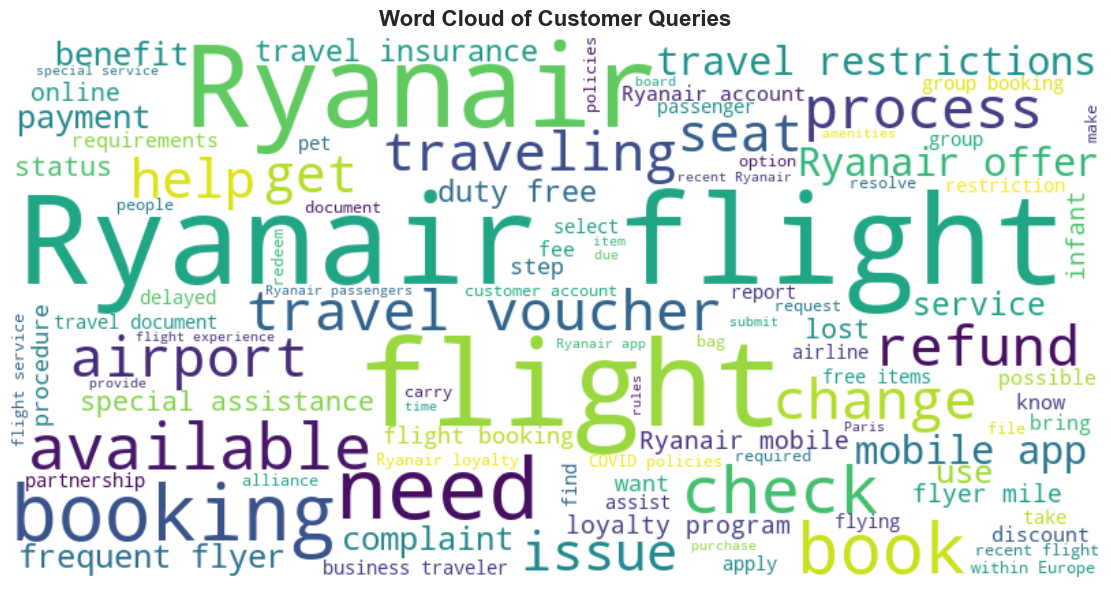

In [19]:
# %%
# Create word cloud
wordcloud_text = ' '.join(train_data['query'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     stopwords=stop_words, max_words=100, colormap='viridis').generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Queries', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# %%
# Common words by category (for top 5 categories)
print(" Common Words by Top Categories:")
print("=" * 40)
top_5_categories = label_counts.head(5).index

for category in top_5_categories:
    category_queries = train_data[train_data['label'] == category]['query']
    category_words = get_common_words(category_queries, n=10)
    print(f"\n{category}:")
    words_str = ', '.join([f"{word} ({count})" for word, count in category_words[:5]])
    print(f"  {words_str}")


 Common Words by Top Categories:

Payment Issues:
  payment (856), flight (384), booking (367), ryanair (294), issue (239)

Complaints and Feedback:
  flight (669), complaint (586), feedback (570), recent (461), ryanair (446)

Lost and Found:
  lost (766), flight (491), ryanair (367), report (312), item (273)

Flight Status:
  flight (836), status (588), check (329), ryanair (243), time (152)

Mobile App Issues:
  app (837), ryanair (620), mobile (581), issues (269), working (211)


##  5. Data Quality Assessment

In [21]:
# %%
# Check for very short or very long queries
print("Data Quality Issues:")
print("=" * 30)

very_short = train_data[train_data['word_count'] <= 2]
very_long = train_data[train_data['word_count'] >= 50]

print(f"Very short queries (≤2 words): {len(very_short)}")
print(f"Very long queries (≥50 words): {len(very_long)}")

if len(very_short) > 0:
    print("\nSample short queries:")
    print(very_short[['query', 'label']].head())

if len(very_long) > 0:
    print("\nSample long queries:")
    print(very_long[['query', 'label']].head())

Data Quality Issues:
Very short queries (≤2 words): 0
Very long queries (≥50 words): 0


In [22]:
# %%
# Check for potential data quality issues
print("Additional Quality Checks:")
print("=" * 35)

# Queries with only punctuation or numbers
pattern_issues = train_data[train_data['query'].str.match(r'^[^a-zA-Z]*$')]
print(f"Queries with no letters: {len(pattern_issues)}")

# Queries with unusual characters
special_chars = train_data[train_data['query'].str.contains(r'[^a-zA-Z0-9\s\.\,\?\!\'\"\-\(\)]')]
print(f"Queries with special characters: {len(special_chars)}")

# Empty or whitespace-only queries
empty_queries = train_data[train_data['query'].str.strip() == '']
print(f"Empty queries: {len(empty_queries)}")

🔍 Additional Quality Checks:
Queries with no letters: 0
Queries with special characters: 5
Empty queries: 0


## 6. Key Insights & Next Steps

In [23]:
# %%
print("KEY INSIGHTS FROM EDA:")
print("=" * 50)
print(f" Dataset Size: {len(train_data):,} training samples, {len(test_data):,} test samples")
print(f" Number of Categories: {len(label_counts)} distinct categories")
print(f" Class Balance: Relatively balanced (ratio: {label_counts.iloc[0] / label_counts.iloc[-1]:.2f}:1)")
print(f" Text Characteristics:")
print(f"   • Average query length: {train_data['query_length'].mean():.1f} characters")
print(f"   • Average word count: {train_data['word_count'].mean():.1f} words")
print(f"   • Text range: {train_data['word_count'].min()}-{train_data['word_count'].max()} words")
print(f" Data Quality: {len(train_data) - very_short.shape[0] - very_long.shape[0]:,} good quality samples")

KEY INSIGHTS FROM EDA:
 Dataset Size: 20,000 training samples, 5,976 test samples
 Number of Categories: 30 distinct categories
 Class Balance: Relatively balanced (ratio: 2.18:1)
 Text Characteristics:
   • Average query length: 71.9 characters
   • Average word count: 13.0 words
   • Text range: 3-47 words
 Data Quality: 20,000 good quality samples


In [24]:
# %%
# Save processed insights for next notebooks
insights_summary = {
    'total_samples': len(train_data),
    'num_categories': len(label_counts),
    'class_balance_ratio': label_counts.iloc[0] / label_counts.iloc[-1],
    'avg_query_length': train_data['query_length'].mean(),
    'avg_word_count': train_data['word_count'].mean(),
    'quality_issues': {
        'very_short': len(very_short),
        'very_long': len(very_long),
        'special_chars': len(special_chars)
    },
    'top_categories': label_counts.head(10).to_dict()
}

# Save insights to file
import json
with open('../reports/eda_insights.json', 'w') as f:
    json.dump(insights_summary, f, indent=2)

print("EDA insights saved to '../reports/eda_insights.json'")
print("\n Exploratory Data Analysis Complete!")
print("Next: Run 02_data_preprocessing.ipynb")

EDA insights saved to '../reports/eda_insights.json'

 Exploratory Data Analysis Complete!
Next: Run 02_data_preprocessing.ipynb
